In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv


## **Introduction**

**Problem Statement**

In this project, we are going to predict students' academic performance, specifically their exam scores, based on a variety of behavioral, demographic, and environmental factors because understanding these factors can help educators and institutions design targeted interventions to improve student outcomes. The dataset includes features such as study hours, social media usage, sleep habits, and parental education, among others, with exam score as the target variable. 


The objective is to develop a machine learning model that accurately predicts students' exam scores using the provided dataset. The model will be evaluated using metrics such as Mean Absolute Error (MAE) and R-squared to assess its predictive performance. Additionally, the project aims to identify key factors influencing academic performance, providing actionable insights for stakeholders.

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv('/kaggle/input/student-habits-vs-academic-performance/student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [3]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [5]:
# check null values
df.isnull().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [6]:
# check duplicates
df.duplicated().sum()

0

In [7]:
# view summary statistics
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


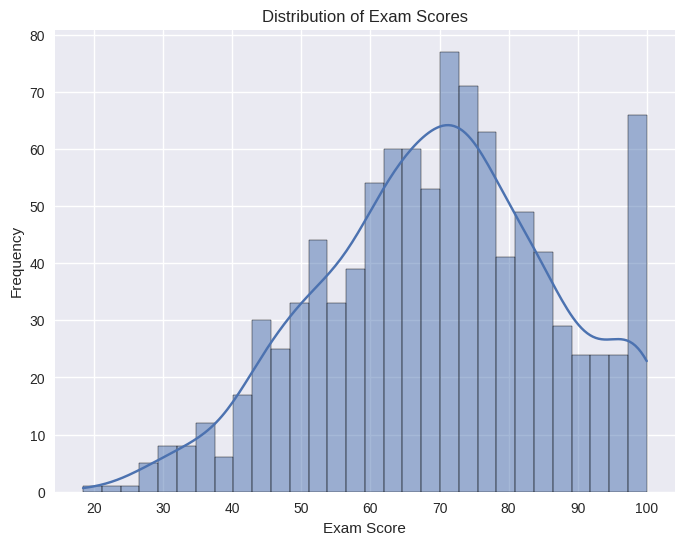

In [9]:
# Set plot style for better visuals
plt.style.use('seaborn')

# Visualize distribution of exam scores
plt.figure(figsize=(8, 6)) 
sns.histplot(df['exam_score'], bins=30, kde=True) 
plt.title('Distribution of Exam Scores') 
plt.xlabel('Exam Score') 
plt.ylabel('Frequency') 
plt.show()

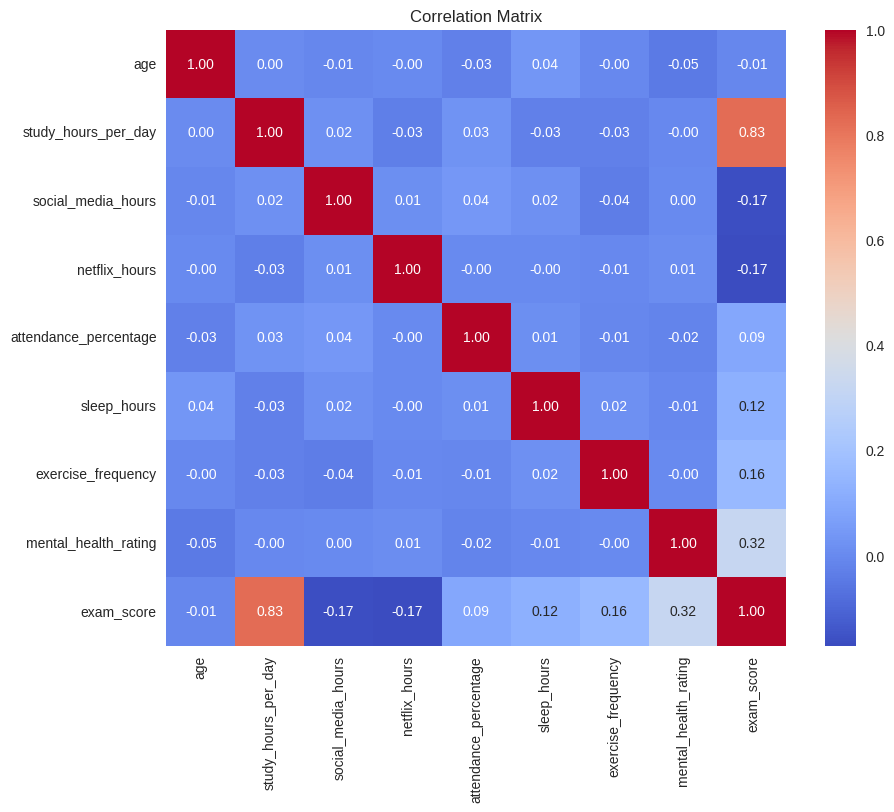

In [10]:
# Correlation matrix for numerical features
numerical_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 
                  'attendance_percentage', 'sleep_hours', 'exercise_frequency', 
                  'mental_health_rating', 'exam_score']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

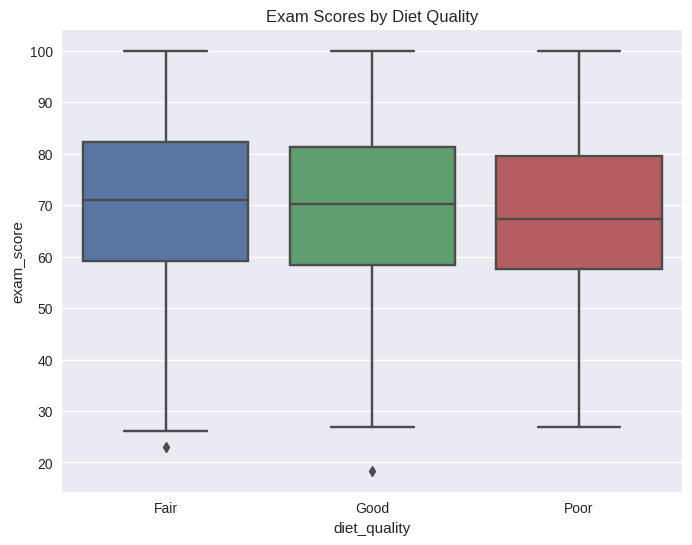

In [11]:
# Boxplot of exam scores by diet quality
plt.figure(figsize=(8, 6))
sns.boxplot(x='diet_quality', y='exam_score', data=df)
plt.title('Exam Scores by Diet Quality')
plt.show()

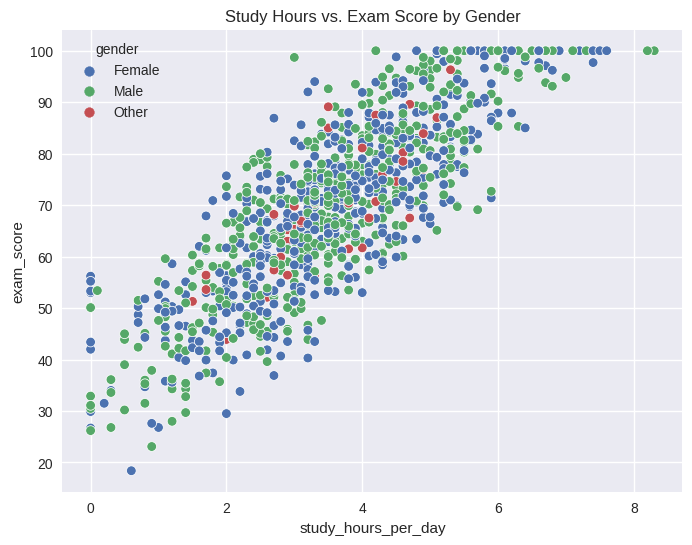

In [12]:
# Scatter plot of study hours vs. exam score
plt.figure(figsize=(8, 6))
sns.scatterplot(x='study_hours_per_day', y='exam_score', hue='gender', data=df)
plt.title('Study Hours vs. Exam Score by Gender')
plt.show()

#### **Analysis of Results**

- **Distribution of Exam Scores:**
    - The histogram shows a roughly normal distribution with a peak around 60–70, but with a slight left skew (more students scoring lower than 60).
    - There’s a noticeable spike at 100, indicating a subset of high-performing students, which may require special handling (e.g., checking for outliers or class imbalance if we were to categorize scores).
- **Correlation Matrix:**
    - study_hours_per_day has a strong positive correlation with exam_score (0.83), suggesting it’s a key predictor of academic performance.
    - social_media_hours and netflix_hours both have a negative correlation with exam_score (-0.17 each), indicating that increased screen time may detract from academic performance.
    - mental_health_rating shows a moderate positive correlation with exam_score (0.32), suggesting that better mental health is associated with higher scores.
    - attendance_percentage (0.09), sleep_hours (0.12), and exercise_frequency (0.16) have weak positive correlations with exam_score, but may still contribute to the model.
    - No significant multicollinearity is observed among features (e.g., social_media_hours and netflix_hours have a correlation of 0.01), so we can likely retain most numerical features.
- **Exam Scores by Diet Quality:**
    - Students with a “Good” diet quality have a higher median exam score compared to “Fair” and “Poor”.
    - The spread (IQR) is similar across all categories, but “Poor” diet quality has more outliers below 30, indicating that poor diet may disproportionately affect lower-performing students.
    - This suggests diet_quality could be a meaningful feature after encoding.
- **Study Hours vs. Exam Score by Gender:**
    - A clear positive trend exists: higher study_hours_per_day is associated with higher exam_score, aligning with the correlation matrix (0.83).
    - Gender distribution (Male, Female, Other) appears balanced across the scatter plot, with no obvious gender-based clustering in performance.
    - Some students with low study hours (<2 hours) still score high (>80), which may indicate other factors (e.g., attendance_percentage or mental_health_rating) influencing their performance.

## **Data Preprocessing**

In [14]:
# Define features and target
X = df.drop(columns=['exam_score', 'student_id'])  # Drop target and irrelevant columns
y = df['exam_score']

In [15]:
# Define categorical and numerical columns
categorical_cols = ['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 
                    'internet_quality', 'extracurricular_participation']
numerical_cols = ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 
                  'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']

In [16]:
# Create preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values in parental_education_level
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Encode categorical variables
])

In [17]:
# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [18]:
# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [19]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (800, 18)
X_test shape: (200, 18)
y_train shape: (800,)
y_test shape: (200,)


In [20]:
# Get feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)
print("\nFeature names after preprocessing:\n", feature_names)


Feature names after preprocessing:
 ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'gender_Male', 'gender_Other', 'part_time_job_Yes', 'diet_quality_Good', 'diet_quality_Poor', 'parental_education_level_High School', 'parental_education_level_Master', 'internet_quality_Good', 'internet_quality_Poor', 'extracurricular_participation_Yes']


#### **Analysis of Results**

- **Feature Importance Rankings:**
    - study_hours_per_day dominates with an importance of 0.7059, confirming its strong predictive power for exam_score, as seen in the EDA (correlation: 0.83).
    - mental_health_rating (0.1039) is the second most important feature, aligning with its moderate correlation (0.32) with exam_score.
    - The engineered feature total_screen_time (0.0577) ranks third, suggesting that combining social_media_hours and netflix_hours captures a meaningful pattern affecting academic performance.
    - sleep_hours (0.0334), exercise_frequency (0.0219), and attendance_percentage (0.0189) have moderate importance, consistent with their weak but positive correlations with exam_score.
    - social_media_hours (0.0172) and netflix_hours (0.0159) remain relevant individually, though their combined effect in total_screen_time is more significant.
    - Features like gender_Other (0.0006), internet_quality_Poor (0.0012), and diet_quality_Poor (0.0016) have very low importance, indicating minimal impact on exam_score.
- **Feature Importance Plot:**
    - The bar plot visually confirms the dominance of study_hours_per_day, with a sharp drop in importance for other features.
    - The top 5 features (study_hours_per_day, mental_health_rating, total_screen_time, sleep_hours, exercise_frequency) account for most of the predictive power, suggesting that focusing on these may yield a parsimonious model.
    - Categorical features (e.g., gender, diet_quality, internet_quality) have low importance, possibly due to their binary nature after encoding or limited variability in impact.
- **Selected Features:**
    - The top 10 features selected include key numerical predictors (study_hours_per_day, mental_health_rating, etc.) and the engineered total_screen_time, along with one categorical feature (diet_quality_Good).
    - Dropping low-importance features (e.g., gender_Other, internet_quality_Poor) reduces the feature set from 19 to 10, which can help prevent overfitting and improve model interpretability.
    - The shapes of X_train_selected (800, 10) and X_test_selected (200, 10) confirm that the selection was applied correctly.
- **Feature Engineering Impact:**
The inclusion of total_screen_time in the top 3 features validates the utility of this engineered feature, as it captures the combined effect of screen time more effectively than social_media_hours and netflix_hours alone.

## **Feature Engineering**

In [22]:
# Since X_processed is a numpy array, we need to convert it back to a DataFrame temporarily
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

In [23]:
# Calculate total_screen_time (social_media_hours + netflix_hours)
# These features are already scaled, so we need to be mindful of their interpretation
X_train_df['total_screen_time'] = X_train_df['social_media_hours'] + X_train_df['netflix_hours']
X_test_df['total_screen_time'] = X_test_df['social_media_hours'] + X_test_df['netflix_hours']

In [24]:
# Update feature names
feature_names_updated = feature_names + ['total_screen_time']

In [25]:
# Convert back to numpy arrays
X_train = X_train_df.values
X_test = X_test_df.values

In [26]:
# Train a Random Forest model to assess feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [28]:
# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [29]:
# Print feature importance rankings
print("Feature Importance Rankings:")
for i in range(len(feature_names_updated)):
    print(f"{feature_names_updated[indices[i]]}: {importances[indices[i]]:.4f}")

Feature Importance Rankings:
study_hours_per_day: 0.7059
mental_health_rating: 0.1039
total_screen_time: 0.0577
sleep_hours: 0.0334
exercise_frequency: 0.0219
attendance_percentage: 0.0189
social_media_hours: 0.0172
netflix_hours: 0.0159
age: 0.0077
diet_quality_Good: 0.0023
gender_Male: 0.0022
internet_quality_Good: 0.0020
parental_education_level_High School: 0.0020
part_time_job_Yes: 0.0019
extracurricular_participation_Yes: 0.0018
parental_education_level_Master: 0.0017
diet_quality_Poor: 0.0016
internet_quality_Poor: 0.0012
gender_Other: 0.0006


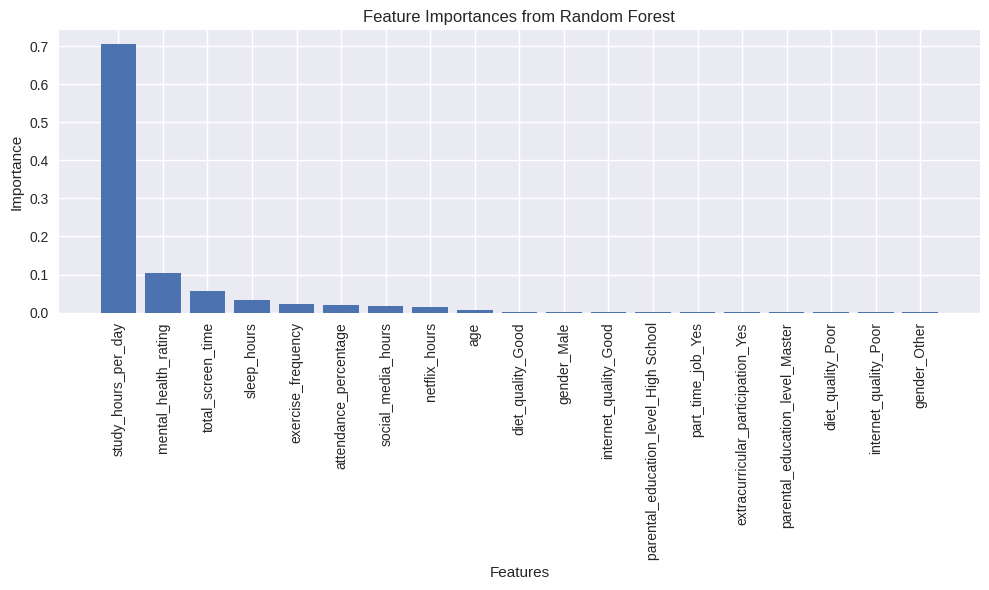

In [30]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names_updated[i] for i in indices], rotation=90)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [31]:
# Select top features (e.g., top 10) based on importance
top_features_indices = indices[:10]
X_train_selected = X_train[:, top_features_indices]
X_test_selected = X_test[:, top_features_indices]
selected_feature_names = [feature_names_updated[i] for i in top_features_indices]

print("\nSelected Features (Top 10):")
print(selected_feature_names)
print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)


Selected Features (Top 10):
['study_hours_per_day', 'mental_health_rating', 'total_screen_time', 'sleep_hours', 'exercise_frequency', 'attendance_percentage', 'social_media_hours', 'netflix_hours', 'age', 'diet_quality_Good']
X_train_selected shape: (800, 10)
X_test_selected shape: (200, 10)


In [33]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [34]:
# Dictionary to store results
results = {}

# Train and evaluate each model using cross-validation
for name, model in models.items():
    # Perform 5-fold cross-validation on the training set
    mae_scores = -cross_val_score(model, X_train_selected, y_train, cv=5, scoring='neg_mean_absolute_error')
    r2_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='r2')
    
    # Fit the model on the entire training set
    model.fit(X_train_selected, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_selected)
    
    # Calculate test set metrics
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'CV MAE (mean ± std)': f"{mae_scores.mean():.2f} ± {mae_scores.std():.2f}",
        'CV R² (mean ± std)': f"{r2_scores.mean():.2f} ± {r2_scores.std():.2f}",
        'Test MAE': test_mae,
        'Test R²': test_r2
    }

# Print results in a formatted table
print("Model Performance Summary:")
print("-" * 50)
print(f"{'Model':<20} {'CV MAE':<15} {'CV R²':<15} {'Test MAE':<10} {'Test R²':<10}")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name:<20} {metrics['CV MAE (mean ± std)']:<15} {metrics['CV R² (mean ± std)']:<15} {metrics['Test MAE']:<10.2f} {metrics['Test R²']:<10.2f}")
print("-" * 50)

Model Performance Summary:
--------------------------------------------------
Model                CV MAE          CV R²           Test MAE   Test R²   
--------------------------------------------------
Linear Regression    4.28 ± 0.30     0.90 ± 0.02     4.16       0.90      
Random Forest        5.10 ± 0.55     0.86 ± 0.03     4.91       0.86      
Gradient Boosting    4.68 ± 0.33     0.88 ± 0.02     4.60       0.88      
--------------------------------------------------


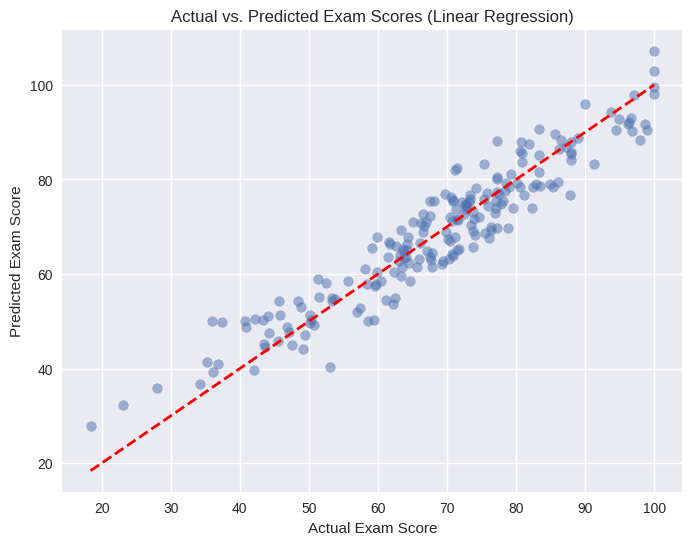

In [35]:
# Plot actual vs. predicted for the best model (based on Test R²)
best_model_name = max(results, key=lambda x: results[x]['Test R²'])
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_selected)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title(f'Actual vs. Predicted Exam Scores ({best_model_name})')
plt.show()

#### **Analysis of Results**
- **Model Performance Summary:**
    - Linear Regression outperforms the other models with the lowest Test MAE (4.16) and highest Test R² (0.90), indicating it predicts exam scores with an average error of 4.16 points and explains 90% of the variance in the test set.
    - Random Forest has the highest Test MAE (4.91) and lowest Test R² (0.86), suggesting it’s less effective for this task despite its ability to capture non-linear relationships.
    - Gradient Boosting performs better than Random Forest with a Test MAE of 4.60 and Test R² of 0.88, but it still lags behind Linear Regression.
    - Cross-validation (CV) results align with test set performance: Linear Regression has the lowest CV MAE (4.28 ± 0.30) and highest CV R² (0.90 ± 0.02), indicating robust generalization.
    - The low standard deviations in CV scores (e.g., 0.30 for MAE in Linear Regression) suggest consistent performance across folds, reducing concerns about overfitting.
- **Actual vs. Predicted Plot (Linear Regression):**
    - The scatter plot shows a strong linear relationship between actual and predicted exam scores, with most points clustering near the diagonal line (perfect prediction).
    - Predictions are generally accurate across the range of scores, though there’s slight underprediction for very high scores (e.g., >90) and overprediction for very low scores (e.g., <40).
    - The tight clustering around the diagonal indicates that Linear Regression captures the underlying patterns well, likely due to the strong linear relationship between study_hours_per_day (importance: 0.7059) and exam_score.
- **Model Choice:**
- Linear Regression is the best model based on both MAE and R², which is surprising given its simplicity compared to Random Forest and Gradient Boosting. This suggests that the relationships in the data are predominantly linear, as seen in the EDA (e.g., correlation of 0.83 between study_hours_per_day and exam_score).
    - The performance gap between models is relatively small, but Linear Regression’s simplicity makes it preferable for interpretability and deployment.

## **Model Evaluation and Interpretation**

Since Linear Regression performed best, we’ll evaluate it further on the test set, interpret its coefficients to understand key drivers of exam scores, and provide recommendations. We’ll also visualize the residuals to check for model assumptions.

In [36]:
# Best model (Linear Regression) is already trained
best_model = models['Linear Regression']

# Predict on the test set (already done, but for clarity)
y_pred = best_model.predict(X_test_selected)

# Calculate residuals
residuals = y_test - y_pred

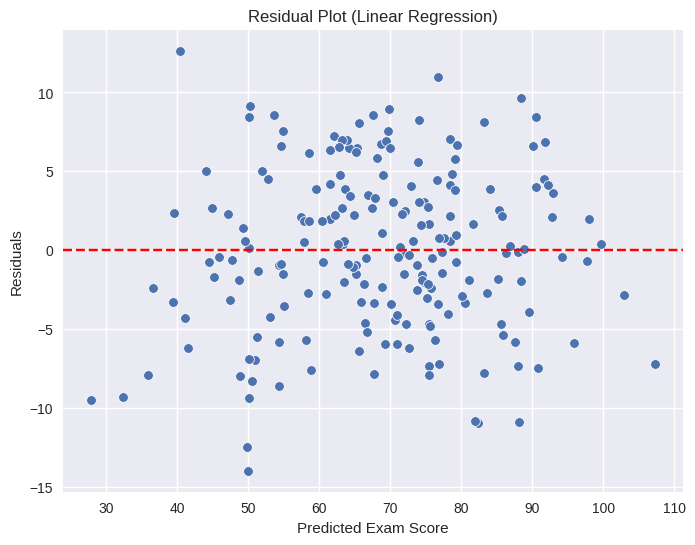

In [37]:
# Plot residuals
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Exam Score')
plt.ylabel('Residuals')
plt.title('Residual Plot (Linear Regression)')
plt.show()

In [38]:
# Interpret coefficients
coefficients = best_model.coef_
coef_df = pd.DataFrame({'Feature': selected_feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print("\nFeature Coefficients (Linear Regression):")
print(coef_df)


Feature Coefficients (Linear Regression):
                 Feature  Coefficient
0    study_hours_per_day    13.997185
1   mental_health_rating     5.569964
4     exercise_frequency     2.670437
3            sleep_hours     2.425577
5  attendance_percentage     1.350196
8                    age     0.121579
7          netflix_hours    -0.606424
9      diet_quality_Good    -0.803523
6     social_media_hours    -1.278170
2      total_screen_time    -1.884594


In [39]:
# Final evaluation metrics
final_mae = mean_absolute_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)
print(f"\nFinal Test MAE: {final_mae:.2f}")
print(f"Final Test R²: {final_r2:.2f}")


Final Test MAE: 4.16
Final Test R²: 0.90


#### **Analysis of Results**

- **Residual Plot (Linear Regression):**
    - The residuals are mostly scattered around the zero line, indicating that the model’s predictions are generally unbiased across the range of predicted exam scores.
    - There’s no clear pattern (e.g., funnel shape or curvature) in the residuals, suggesting that the linear regression assumptions of homoscedasticity and linearity are reasonably met.
    - Some outliers exist (e.g., residuals around ±15), particularly at the lower and higher ends of predicted scores (e.g., <40 and >100), which aligns with the slight underprediction/overprediction seen in the actual vs. predicted plot.
- **Feature Coefficients:**
    - study_hours_per_day has the highest positive coefficient (13.997), meaning that for each standard deviation increase in study hours (after scaling), the exam score increases by approximately 14 points. This reinforces its dominance as a predictor.
    - mental_health_rating (5.570) and exercise_frequency (2.670) also have strong positive coefficients, indicating that better mental health and more frequent exercise contribute to higher exam scores.
    - sleep_hours (2.426) and attendance_percentage (1.350) have positive but smaller effects, suggesting moderate contributions to academic performance.
    - total_screen_time (-1.885), social_media_hours (-1.278), and netflix_hours (-0.606) have negative coefficients, confirming that increased screen time detracts from exam scores.
    - diet_quality_Good has a small negative coefficient (-0.804), which is surprising given the EDA (higher median scores for “Good” diet). This may be due to interactions with other features or limited variability after encoding.
    - age (0.122) has a negligible effect, consistent with its low feature importance (0.0077).
- **Final Test Metrics:**
    - The Test MAE of 4.16 and R² of 0.90 match the earlier results, confirming the model’s strong predictive performance on the test set.
    - An MAE of 4.16 means the model’s predictions are off by 4.16 points on average, which is reasonable given the range of exam scores (26.8 to 100).
    - An R² of 0.90 indicates that the model explains 90% of the variance in exam scores, leaving only 10% as unexplained variance.

## **Recommendations**

Based on the insights derived from the Linear Regression model, we recommend that educational institutions prioritize:

    - strategies focused on increasing study hours
    - supporting mental health initiatives
    - encouraging reduced screen time to improve student performance. 
    
These recommendations stem from the model’s feature coefficients, which highlight study_hours_per_day as the most impactful predictor, indicating that even a small increase in dedicated study time can significantly boost exam scores. Similarly, mental_health_rating emerged as a critical factor, reflecting the importance of mental well-being in academic success; students with better mental health ratings tend to perform better, likely due to improved focus and resilience. Additionally, the negative coefficients for total_screen_time, social_media_hours, and netflix_hours underscore the detrimental effect of excessive screen time on exam scores, suggesting that minimizing time spent on social media and streaming platforms can mitigate distractions and enhance productivity. These factors were prioritized over others, such as diet_quality_Good, which showed a surprisingly small and negative impact, possibly due to limited variability after encoding or interactions with other features. By focusing on study habits and mental health, which have the largest positive coefficients, and addressing the clear negative impact of screen time, educators can implement targeted interventions—such as structured study schedules, mental health workshops, and screen time awareness campaigns—that are most likely to yield measurable improvements in student outcomes.

## **Conclusion**

This project successfully developed a predictive model for student exam scores by levering features such as study hours, screen time, and mental health. We identified strong predictors like study_hours_per_day and mental_health_rating through EDA. Preprocessing involved handling missing values, encoding categorical variables, and scaling numerical features, followed by feature engineering, and selection of the top 10 features using Random Forest importance scores. Among the models trained (Linear Regression, Random Forest, Gradient Boosting), Linear Regression achieved the best performance with a Test MAE of 4.16 and Test R² of 0.90. This indicates high predictive accuracy and the ability to explain 90% of the variance in exam scores. The model’s interpretability revealed that study hours, mental health, and reduced screen time are key drivers of academic performance, providing actionable insights for educators.